In [1]:
# Gaussian Process Regression Code #
# Running GPR model separately due to long run time #

In [22]:
#Read in the packages to use
import numpy as np
import pandas as pd
import math
import datetime
import os
import pathlib
import matplotlib.pyplot as plt
import earthpy as et
import pandas as pd
import pickle
#for displaying the cities on map
import cartopy
import cartopy.crs as ccrs

#models
from sklearn.linear_model import LinearRegression 
import statsmodels.api as sm                                          #stats models to get linear reg p-values
from statsmodels.tools.eval_measures import rmse                      #calc rmse from stats models
import itertools                                                      #for calculating possible combinations of variables
from sklearn.preprocessing import PolynomialFeatures                  #for polynomial regression
from sklearn.pipeline import make_pipeline                            #pipeline to create polynomial regression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF                      #import the kernels for GPR
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
#use grid search to find hyperparameters (pg 73 Geron) RFR
from sklearn.model_selection import GridSearchCV                      #for cross validation
from sklearn.feature_selection import RFE                             #for selecting features for the linear reg
from sklearn.model_selection import cross_val_score                   #for cross validation
from sklearn.model_selection import KFold                            
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler                      #for normalising the data
from sklearn.metrics import r2_score                                  #metrics for assessing model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#for plotting
from matplotlib import ticker 
from matplotlib.ticker import MaxNLocator                             #to keep whole numbers on the x-axis
from matplotlib.lines import Line2D                                   #for manual legend creation

#for timing how long the GPR takes to fit 
from time import time
#Read in the data

#read in the city info table
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx', index_col=None)

#remove cities with area of less than 10km2
CITY_COUNTRY_lat_lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['Area_2002']>9].reset_index()

#read the table with all variables in as pickle
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))   
with open('aqua_all_monthly_data_df2.pkl', 'rb') as f:
    all_monthly_data_df = pickle.load(f)

# remove years after 2015 until have sorted the area data for 2016-2020
all_monthly_data_df = all_monthly_data_df[all_monthly_data_df.year <= 2015]

#remove nans
#all_monthly_data_df = all_monthly_data_df[(~np.isnan(all_monthly_data_df['rur_mean_evi'])
#                    ) & (~np.isnan(all_monthly_data_df['urb_mean_evi'])
#                    ) & (~np.isnan(all_monthly_data_df['a0']))].copy()

# URBAN - RURAL differences
# add evi difference variable
all_monthly_data_df['evi_diff'] = all_monthly_data_df['urb_mean_evi'] - all_monthly_data_df['rur_mean_evi'] 
# add in climate difference variables
all_monthly_data_df['evap_fract_diff'] = all_monthly_data_df['urban_evap_fract'] - all_monthly_data_df['rural_evap_fract'] 
all_monthly_data_df['rh_diff'] = all_monthly_data_df['urban_rh'] - all_monthly_data_df['rural_rh']
all_monthly_data_df['tp_diff'] = all_monthly_data_df['urban_tp'] - all_monthly_data_df['rural_tp']
all_monthly_data_df['ssr_diff'] = all_monthly_data_df['urban_ssr'] - all_monthly_data_df['rural_ssr']

# add in the log_area_x_ef variable 
# Define the ef function
def logarea_ef(x_ef, threshold_ef, m, c):
    x, ef = x_ef
    y = m*(x * (ef - threshold_ef)) + c
    return y
# set values of the area function parameters
threshold_ef = 0.498 
m = 6.622
c = 2.797
x_ef = np.log10(all_monthly_data_df.Area.values.astype(float)), all_monthly_data_df.annual_rural_ef

all_monthly_data_df['log_area_x_rur_ef'] = logarea_ef(x_ef, threshold_ef, m, c)

#split into training and test data
#take the test data as 4 cities, the training as 14?
#or test as 3 cities, training as 15

#define the test cities to remove
test_cities = ['Sikasso', 'Anapolis', 'Campo_Grande', 'Bobo_Dioulasso', 'Diwaniyah', 'Al_Obeid', 'Akola', 'Potiskum','Cascavel']

#define the overpass time 
overpass_time = '13:30'

#define the predictor and target values for training and test data
#what predictors to use?
predictor_variables_all = ['evap_fract_diff', 'rural_evap_fract', 'rh_diff', 'rural_rh','tp_diff' ,'rural_tp', 
                           'rural_t2m','ssr_diff','rural_ssr','rur_mean_evi', 'evi_diff', 'log_area_x_rur_ef',
                           'Eccentricity']

# just ssr and ef
predictor_variables_1 = ['evap_fract_diff', 'rural_evap_fract','ssr_diff','rural_ssr','rur_mean_evi', 'evi_diff', 
                         'log_area_x_rur_ef', 'Eccentricity']

# rh instead of ef
predictor_variables_2 = ['rh_diff', 'rural_rh','ssr_diff','rural_ssr','rur_mean_evi', 'evi_diff', 
                         'log_area_x_rur_ef', 'Eccentricity']


predictor_variables = predictor_variables_1

target_variable = 'a0'
#target_variable = 'method_2_SUHI'
#target_variable = 'quantile_a0'

#clean the data - first remove columns which are not the target or predictor variables, then remove nans
variables = predictor_variables.copy()
variables.append(target_variable)
variables.append('City')
variables.append('Overpass')
all_monthly_data_df2 = all_monthly_data_df[variables]
all_monthly_data_df2 = all_monthly_data_df2.dropna()

#create training and test datasets
training_data = all_monthly_data_df2[((~all_monthly_data_df2['City'].isin(test_cities)) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()
test_data = all_monthly_data_df2[((all_monthly_data_df2['City'].isin(test_cities))
                                  & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

print('Train_percent', 100* len(training_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))
print('Test_percent', 100* len(test_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))
print('Total Datapoints',len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))

#split the data into training and test

X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

X_test = test_data[predictor_variables]       #predictors
y_test = test_data[target_variable]           #target

#get the groups
groups_train = training_data.City
groups_test = test_data.City

#create normalised datasets
#the test dataset is normalised using the normalisation parameters from the training data
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only
y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only


Train_percent 78.53674870249456
Test_percent 21.46325129750544
Total Datapoints 5973


In [ ]:
#############################################
######## GAUSSIAN PROCESS REGRESSION ########
#############################################

gpr = GaussianProcessRegressor()               # define the model

RBF_kernel = RBF()                             # define the kernels
Dot_Product_kernel = DotProduct()
Matern_kernel = Matern()
#carry out cross validation
folds = 5                                                                       #define the number of folds (K)
#specify the hyperparameters to test

hyper_params = [{'kernel':[RBF_kernel]                # using the RBF kernel
                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    # e-10 is the default alpha (value added to cov matrix diagonal)
                ,'n_restarts_optimizer':[0,20,50]          # number of restarts for the optimizer to find kernels parameters    
            } ,{'kernel':[Dot_Product_kernel]         # using the dot prod kernel
                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    
                ,'n_restarts_optimizer':[0,20,50] 
            }  ,{'kernel':[Matern_kernel]             # using the Matern kernel
                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    
                ,'n_restarts_optimizer':[0,20,50] 
            }]                 


#hyper_params = [{'kernel':[RBF_kernel]                # using the RBF kernel
#                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    # e-10 is the default alpha (value added to cov matrix diagonal)
#                ,'n_restarts_optimizer':[0,20,50]          # number of restarts for the optimizer to find kernels parameters    
#                }]   

print("Fitting the GPR model...")
from datetime import datetime
startTime = datetime.now()

#default value for max_iter = 1000
model_cv = GridSearchCV(estimator = gpr, 
                        param_grid = hyper_params, 
                        #scoring= 'r2',                        
                        cv = folds, 
                        verbose = 1,                                  #verbose- how detailed output is   
                        return_train_score=True) 

#fit the model
model_cv.fit(X_train_norm, y_train_norm)  

#cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

#save the model 
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))  
filename = 'finalised_model_gpr_a0.sav'
pickle.dump(model_cv, open(filename, 'wb'))


Fitting the GPR model...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packag

In [ ]:

############ TARGET VARIABLE NOT NORMALISED ################

#############################################
######## GAUSSIAN PROCESS REGRESSION ########
#############################################

gpr = GaussianProcessRegressor()               # define the model

RBF_kernel = RBF()                             # define the kernels
Dot_Product_kernel = DotProduct()
Matern_kernel = Matern()
#carry out cross validation
folds = 5                                                                       #define the number of folds (K)
#specify the hyperparameters to test

hyper_params = [{'kernel':[RBF_kernel]                # using the RBF kernel
                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    # e-10 is the default alpha (value added to cov matrix diagonal)
                ,'n_restarts_optimizer':[0,20,50]          # number of restarts for the optimizer to find kernels parameters    
            } ,{'kernel':[Dot_Product_kernel]         # using the dot prod kernel
                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    
                ,'n_restarts_optimizer':[0,20,50] 
            }  ,{'kernel':[Matern_kernel]             # using the Matern kernel
                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    
                ,'n_restarts_optimizer':[0,20,50] 
            }]                 


#hyper_params = [{'kernel':[RBF_kernel]                # using the RBF kernel
#                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    # e-10 is the default alpha (value added to cov matrix diagonal)
#                ,'n_restarts_optimizer':[0,20,50]          # number of restarts for the optimizer to find kernels parameters    
#                }]   

print("Fitting the GPR model...")
from datetime import datetime
startTime = datetime.now()

#default value for max_iter = 1000
model_cv = GridSearchCV(estimator = gpr, 
                        param_grid = hyper_params, 
                        #scoring= 'r2',                        
                        cv = folds, 
                        verbose = 1,                                  #verbose- how detailed output is   
                        return_train_score=True) 

#fit the model
model_cv.fit(X_train_norm, y_train)  

#cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

#save the model 
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))  
filename = 'y_not_norm_model_gpr_a0.sav'
pickle.dump(model_cv, open(filename, 'wb'))


Fitting the GPR model...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packag

C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
  

C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
  

In [24]:
model_cv.best_params_

{'alpha': 0.01, 'kernel': DotProduct(sigma_0=1), 'n_restarts_optimizer': 20}

In [3]:
#read in the model
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))  
filename = 'finalised_model_gpr_a0.sav'
model_gpr_target_a0 = pickle.load(open(filename, 'rb'))

In [4]:
model_cv = model_gpr_target_a0

In [5]:
model_cv.best_params_

{'alpha': 0.001, 'kernel': DotProduct(sigma_0=1), 'n_restarts_optimizer': 20}

In [6]:
#Performance stats for gaussian porcess regression
# Use model to make predictions
y_train_pred = model_cv.predict(X_train_norm)
y_test_pred = model_cv.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_gpr_mse = mean_squared_error(y_train_norm, y_train_pred)
train_gpr_rmse = np.sqrt(train_gpr_mse)
#r-square
train_gpr_r2 = r2_score(y_train_norm, y_train_pred)
#mae
train_gpr_mae = mean_absolute_error(y_train_norm, y_train_pred)
print('Training Metrics--', 'RMSE:', train_gpr_rmse, 'R-square:', train_gpr_r2, 'MAE:', train_gpr_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_gpr_mse = mean_squared_error(y_test_norm, y_test_pred)
test_gpr_rmse = np.sqrt(test_gpr_mse)
#r-square
test_gpr_r2 = r2_score(y_test_norm, y_test_pred)
#mae
test_gpr_mae = mean_absolute_error(y_test_norm, y_test_pred)
print('Test Metrics--', 'RMSE:', test_gpr_rmse, 'R-square:', test_gpr_r2, 'MAE:', test_gpr_mae)


Training Metrics-- RMSE: 0.5503518860383964 R-square: 0.69711280153398 MAE: 0.41192188184697
Test Metrics-- RMSE: 0.45420661724317285 R-square: 0.6834006741963237 MAE: 0.34439461190952964


In [7]:
y_train_pred_2 = scaler.inverse_transform(y_train_pred)
y_test_pred_2 = scaler.inverse_transform(y_test_pred)

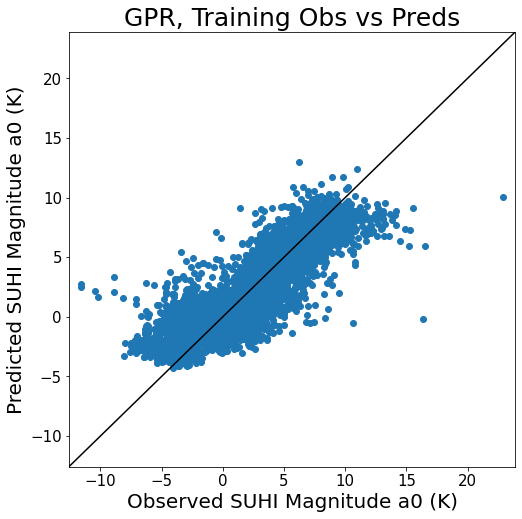

In [8]:
# Look at obs vs preds
# TRAINING #

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title


fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_train, y_train_pred_2)
axes.set(title = 'GPR, Training Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred_2)) - 1
axesmax = max(max(y_train), max(y_train_pred_2)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

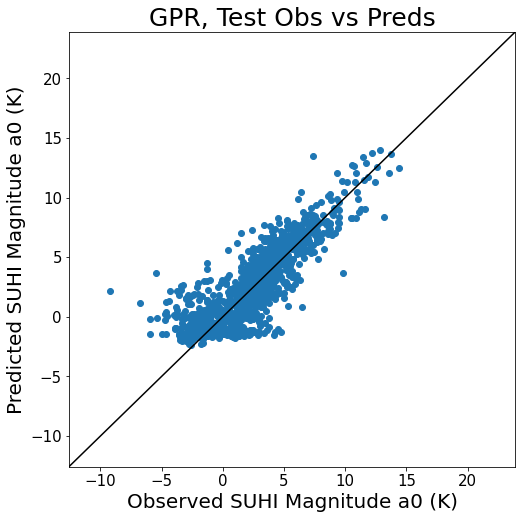

In [9]:
# Look at obs vs preds
# TEST #

fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_test, y_test_pred_2)
axes.set(title = 'GPR, Test Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

#axesmin = min(min(y_test), min(y_test_pred_2)) - 1
#axesmax = max(max(y_test), max(y_test_pred_2)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')